# Training Model with Beeldmaterial (5m) Orthophotos: Using RGB Bands

In [1]:
import os
import shutil
import random
from math import ceil
import hashlib
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from rasterio.windows import Window
from rasterio.windows import bounds as win_bounds
from rasterio.windows import from_bounds as win_from_bounds
from rasterio.coords import BoundingBox
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling

## Data Loading

In [2]:
rgb_folder = "../data/5m_rgb"
cir_folder = "../data/5m_cir"
lulc_raster = "../data/lulc/three_class.tif"

### Visualising Ground Truth

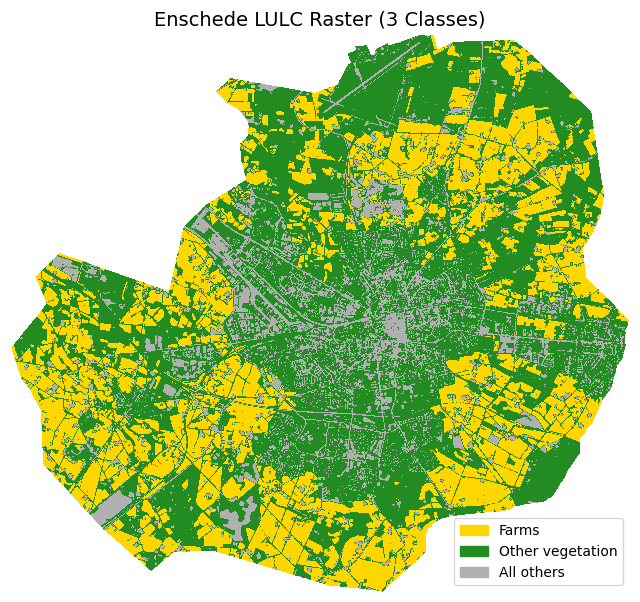

In [3]:
with rasterio.open(lulc_raster) as src:
    lulc_data = src.read(1)
    lulc_meta = src.meta.copy()
    nodata_value = src.nodata

# --- Mask NoData values ---
if nodata_value is not None:
    lulc_data = np.ma.masked_equal(lulc_data, nodata_value)
else:
    if 0 in np.unique(lulc_data):
        lulc_data = np.ma.masked_equal(lulc_data, 0)

# --- Define colours and labels ---
# 1 = Farms, 2 = Other vegetation, 3 = All others
colors = ["#FFD700", "#228B22", "#B0B0B0"]  # yellow, green, grey
labels = ["Farms", "Other vegetation", "All others"]

# --- Create colormap and normalisation ---
cmap = ListedColormap(colors)
bounds = [0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(bounds, cmap.N)

# --- Plot ---
plt.figure(figsize=(8, 8))
im = plt.imshow(lulc_data, cmap=cmap, norm=norm)
plt.title("Enschede LULC Raster (3 Classes)", fontsize=14)
plt.axis("off")

# --- Add legend ---
legend_patches = [Patch(color=c, label=l) for c, l in zip(colors, labels)]
plt.legend(handles=legend_patches, loc="lower right", frameon=True)

plt.show()

### Creating Train/Test Tiles

In [4]:
# --- Define source and destination folders ---
rgb_folder   = Path("../data/5m_rgb")       # source folder with all RGB tiles
train_folder = Path("../data/train_rgb")
test_folder  = Path("../data/test_rgb")

# --- Create destination folders if they don't exist ---
train_folder.mkdir(parents=True, exist_ok=True)
test_folder.mkdir(parents=True, exist_ok=True)

# --- List all RGB tiles (in .tif format) ---
rgb_tiles = [f for f in os.listdir(rgb_folder) if f.lower().endswith(".tif")]
total_tiles = len(rgb_tiles)
print(f"Total RGB tiles found: {total_tiles}")

# --- Stable hash key for each filename (MD5, deterministic) ---
def stable_key(name: str) -> int:
    return int(hashlib.md5(name.encode("utf-8")).hexdigest(), 16)

# --- Sort by stable hash to de-cluster, then take exact 30% as test ---
rgb_tiles_sorted = sorted(rgb_tiles, key=stable_key)

k_test = int(round(0.30 * total_tiles))  # exact 30% (14/6 for 20 files)
# Optional: ensure at least 1 test tile if dataset is tiny
k_test = max(1, min(total_tiles - 1, k_test))

test_tiles  = rgb_tiles_sorted[:k_test]
train_tiles = rgb_tiles_sorted[k_test:]

print(f"Training tiles: {len(train_tiles)}")
print(f"Testing tiles:  {len(test_tiles)}")

# --- Copy tiles to respective folders ---
for f in train_tiles:
    shutil.copy2(rgb_folder / f, train_folder / f)

for f in test_tiles:
    shutil.copy2(rgb_folder / f, test_folder / f)

print("Files copied successfully.")

Total RGB tiles found: 20
Training tiles: 14
Testing tiles:  6
Files copied successfully.


### Creating Train/Test Labels

In [5]:
rgb_folder_path = Path(rgb_folder)
lulc_path = Path(lulc_raster)

out_train = Path("../data/lulc_tiles_train")
out_test  = Path("../data/lulc_tiles_test")
out_train.mkdir(parents=True, exist_ok=True)
out_test.mkdir(parents=True, exist_ok=True)

def write_label_tiles(tile_names, out_dir):
    with rasterio.open(lulc_path) as lulc_src:
        # Pick safe dtype for categorical labels
        src_dtype = lulc_src.dtypes[0]
        out_dtype = rasterio.uint8 if src_dtype in ("uint8", "int8") else src_dtype

        total = len(tile_names)
        for i, fname in enumerate(tile_names, start=1):
            rgb_path = rgb_folder_path / fname
            if not rgb_path.exists():
                print(f"Skipping (missing RGB tile): {rgb_path.name}")
                continue

            with rasterio.open(rgb_path) as rgb_src:
                # Present LULC in the exact grid of this RGB tile
                with WarpedVRT(
                    lulc_src,
                    crs=rgb_src.crs,
                    transform=rgb_src.transform,
                    width=rgb_src.width,
                    height=rgb_src.height,
                    resampling=Resampling.nearest,
                    src_nodata=lulc_src.nodata,
                    nodata=lulc_src.nodata,
                ) as lulc_on_rgb:

                    # Read full tile window
                    win = Window(0, 0, rgb_src.width, rgb_src.height)
                    label_arr = lulc_on_rgb.read(1, window=win, out_dtype=out_dtype)

                    # Minimal single-band profile (avoid YCbCr/StripOffsets issues)
                    profile = {
                        "driver": "GTiff",
                        "height": rgb_src.height,
                        "width":  rgb_src.width,
                        "count":  1,
                        "dtype":  out_dtype,
                        "crs":    rgb_src.crs,
                        "transform": rgb_src.transform,
                    }
                    if lulc_src.nodata is not None:
                        profile["nodata"] = int(lulc_src.nodata)

                    out_path = out_dir / fname
                    # Remove any pre-existing file (in case of partial writes)
                    try:
                        out_path.unlink(missing_ok=True)
                    except TypeError:
                        if out_path.exists():
                            out_path.unlink()

                    with rasterio.open(out_path, "w", **profile) as dst:
                        dst.write(label_arr, 1)

            if i % 10 == 0 or i == total:
                print(f"{out_dir.name}: wrote {i}/{total} tiles")

# Write TRAIN and TEST label tiles
write_label_tiles(train_tiles, out_train)
write_label_tiles(test_tiles,  out_test)

print(f"Train labels: {out_train.resolve()} \n Test labels:  {out_test.resolve()}")

lulc_tiles_train: wrote 10/14 tiles
lulc_tiles_train: wrote 14/14 tiles
lulc_tiles_test: wrote 6/6 tiles
Train labels: /data/private/group/data/lulc_tiles_train 
 Test labels:  /data/private/group/data/lulc_tiles_test


## Using RGB Bands

### Model Creation

In [6]:
# =========================
# CONFIG for sensitivity runs
# =========================
CFG = {
    # Data / patching
    "patch_size": 256,              
    "stride": None,                 
    "num_epochs": 1,
    "ignore_index": 255,
    "num_classes": 3,               

    # Model capacity
    "unet_depth": 4,                
    "base_filters": 32,             
    "use_batchnorm": True,          
    "dropout_p": 0.0,               

    # Optimizer / LR
    "optimizer": "adamw",           
    "learning_rate": 1e-3,          
    "weight_decay": 1e-4,           

    # Loss & class imbalance
    "loss_type": "ce",              
    "dice_alpha": 0.5,              
    "focal_gamma": 2.0,             
    "class_weights": "none",        
    "precomputed_counts": None,     

    # Training tricks
    "accum_steps": 4,               
    "use_amp": True,                

    # Augmentations (applied per patch)
    "aug_strength": "none",        
}

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
PATCH_SIZE   = CFG["patch_size"]
STRIDE       = (CFG["patch_size"] // 2) if CFG["stride"] is None else CFG["stride"]
NUM_EPOCHS   = CFG["num_epochs"]
IGNORE_INDEX = CFG["ignore_index"]
NUM_CLASSES  = CFG["num_classes"]
ACCUM_STEPS  = CFG["accum_steps"]
USE_AMP      = CFG["use_amp"]

# =========================
# UNet factory (variable depth/base, BN on/off, dropout)
# =========================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, use_bn=True, p_drop=0.0):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        ]
        if use_bn: layers.insert(1, nn.BatchNorm2d(out_ch))
        if p_drop > 0: layers.append(nn.Dropout2d(p_drop))

        layers2 = [
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        ]
        if use_bn: layers2.insert(1, nn.BatchNorm2d(out_ch))
        if p_drop > 0: layers2.append(nn.Dropout2d(p_drop))

        self.block = nn.Sequential(*layers, *layers2)

    def forward(self, x): return self.block(x)

class UNetFlex(nn.Module):
    """
    depth: number of encoding levels (>=3).
    base:  number of base filters.
    """
    def __init__(self, in_ch=3, n_classes=3, base=32, depth=4, use_bn=True, p_drop=0.0):
        super().__init__()
        assert depth >= 3, "UNet depth must be >= 3"
        self.depth = depth

        # Encoder
        encs = []
        chans = [base * (2**i) for i in range(depth)]
        encs.append(DoubleConv(in_ch, chans[0], use_bn, p_drop))
        for i in range(1, depth):
            encs.append(DoubleConv(chans[i-1], chans[i], use_bn, p_drop))
        self.encs = nn.ModuleList(encs)
        self.pools = nn.ModuleList([nn.MaxPool2d(2) for _ in range(depth-1)])

        # Decoder
        ups  = []
        decs = []
        for i in reversed(range(1, depth)):
            ups.append(nn.ConvTranspose2d(chans[i], chans[i-1], 2, stride=2))
            decs.append(DoubleConv(chans[i] , chans[i-1], use_bn, p_drop))  # concat doubles ch then conv back
        self.ups  = nn.ModuleList(ups)
        self.decs = nn.ModuleList(decs)

        self.out = nn.Conv2d(chans[0], n_classes, 1)

    def forward(self, x):
        feats = []
        z = x
        for i in range(self.depth):
            z = self.encs[i](z)
            feats.append(z)
            if i < self.depth-1:
                z = self.pools[i](z)
        # decode
        for j in range(self.depth-2, -1, -1):
            z = self.ups[self.depth-2 - j](z)
            z = torch.cat([z, feats[j]], dim=1)
            z = self.decs[self.depth-2 - j](z)
        return self.out(z)

# =========================
# Losses (CE, Dice, CE+Dice, Focal)
# =========================
class DiceLoss(nn.Module):
    def __init__(self, ignore_index=255, eps=1e-6):
        super().__init__()
        self.ignore_index = ignore_index
        self.eps = eps

    def forward(self, logits, target):
        # logits: (N,C,H,W), target: (N,H,W) in {0..C-1 or ignore}
        N, C, H, W = logits.shape
        valid = (target != self.ignore_index)
        if not valid.any():
            return logits.new_zeros(())
        target_valid = target.clone()
        target_valid[~valid] = 0

        probs = F.softmax(logits, dim=1)                       # (N,C,H,W)
        probs = probs.permute(0,2,3,1)[valid]                  # (V,C)
        target_oh = F.one_hot(target_valid[valid], num_classes=C).float()  # (V,C)

        inter = (probs * target_oh).sum(dim=0)                 # (C,)
        denom = probs.sum(dim=0) + target_oh.sum(dim=0)        # (C,)
        dice = (2*inter + self.eps) / (denom + self.eps)
        return 1.0 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, ignore_index=255, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.weight = weight

    def forward(self, logits, target):
        # mask ignore
        valid = (target != self.ignore_index)
        if not valid.any():
            return logits.new_zeros(())
        logits = logits.permute(0,2,3,1)[valid]   # (V,C)
        target = target[valid]                    # (V,)
        logpt = F.log_softmax(logits, dim=-1)
        pt = logpt.exp()
        # gather log prob of true class
        logpt = logpt.gather(1, target.unsqueeze(1)).squeeze(1)
        pt    = pt.gather(1, target.unsqueeze(1)).squeeze(1)
        loss = -(1-pt)**self.gamma * logpt
        if self.weight is not None:
            w = self.weight.to(logits.device)
            loss = loss * w[target]
        return loss.mean()

def make_loss(loss_type="ce", ignore_index=255, class_weights=None, dice_alpha=0.5, focal_gamma=2.0):
    if class_weights is not None:
        class_weights = torch.tensor(class_weights, dtype=torch.float32)
    if loss_type == "ce":
        return nn.CrossEntropyLoss(ignore_index=ignore_index, weight=class_weights)
    elif loss_type == "ce_dice":
        ce = nn.CrossEntropyLoss(ignore_index=ignore_index, weight=class_weights)
        dice = DiceLoss(ignore_index=ignore_index)
        def mixed(logits, target):
            return (1 - dice_alpha) * ce(logits, target) + dice_alpha * dice(logits, target)
        return mixed
    elif loss_type == "focal":
        return FocalLoss(gamma=focal_gamma, ignore_index=ignore_index, weight=class_weights)
    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")

# =========================
# Simple paired augmentations
# =========================
rng = np.random.default_rng(42)

def augment_pair(img_chw, lab_hw, strength="none"):
    # img_chw: (C,H,W), lab_hw: (H,W), both numpy
    if strength == "none":
        return img_chw, lab_hw

    def hflip(a): return a[..., ::-1]
    def vflip(a): return a[..., ::-1, :]
    def rot90(a,k): return np.rot90(a, k=k, axes=(-2,-1))

    # choose ops
    do_h = rng.random() < (0.5 if strength in ("light","medium") else 0.0)
    do_v = rng.random() < (0.2 if strength == "medium" else 0.0)
    krot = (rng.integers(0,4) if strength == "medium" else 0)

    if do_h:
        img_chw = img_chw[:, :, ::-1]
        lab_hw  = lab_hw[:, ::-1]
    if do_v:
        img_chw = img_chw[:, ::-1, :]
        lab_hw  = lab_hw[::-1, :]
    if krot:
        img_chw = rot90(img_chw, krot)
        lab_hw  = rot90(lab_hw, krot)

    return img_chw, lab_hw

# =========================
# Windowing & normalization
# =========================
def iter_windows_full(height, width, patch, stride):
    max_row = height - patch
    max_col = width  - patch
    if max_row < 0 or max_col < 0:
        return
    for row in range(0, max_row + 1, stride):
        for col in range(0, max_col + 1, stride):
            yield Window(col_off=col, row_off=row, width=patch, height=patch)

def normalize_img(img_hwcn):
    img = img_hwcn.astype(np.float32)
    if img_hwcn.dtype == np.uint8:
        img /= 255.0
    elif img_hwcn.dtype == np.uint16:
        img /= 65535.0
    mean = img.reshape(-1, img.shape[-1]).mean(axis=0)
    std  = img.reshape(-1, img.shape[-1]).std(axis=0) + 1e-6
    img = (img - mean) / std
    return np.transpose(img, (2, 0, 1)).astype(np.float32)


## Training

In [7]:
rgb_folder_path    = Path("../data/train_rgb")
label_train_folder = Path("../data/lulc_tiles_train")  

assert isinstance(train_tiles, list) and len(train_tiles) > 0, "train_tiles list is empty or undefined."

# ---------- Compute class weights from training labels ----------
def compute_class_counts(tile_names, label_dir):
    counts = np.zeros(NUM_CLASSES, dtype=np.int64)  # for classes 1..NUM_CLASSES
    for fname in tile_names:
        p = label_dir / fname
        if not p.exists():
            continue
        with rasterio.open(p) as ds:
            lab = ds.read(1)
            # Count only labels in {1..NUM_CLASSES}
            for c in range(1, NUM_CLASSES+1):
                counts[c-1] += np.count_nonzero(lab == c)
    return counts

def calc_class_weights(mode, counts):
    if mode == "none" or counts is None:
        return None
    counts = counts.astype(np.float64) + 1e-6
    if mode == "inv":
        w = 1.0 / counts
    elif mode == "sqrt_inv":
        w = 1.0 / np.sqrt(counts)
    elif mode == "precomputed":

        pc = np.asarray(CFG["precomputed_counts"], dtype=np.float64) + 1e-6
        w = 1.0 / pc if CFG["class_weights"] == "inv" else 1.0 / np.sqrt(pc)
        return (w / w.mean()).astype(np.float32)
    else:
        return None
    return (w / w.mean()).astype(np.float32)

counts_for_weights = None
if CFG["class_weights"] in ("inv", "sqrt_inv"):
    print("Computing class counts for weights...")
    counts_for_weights = compute_class_counts(train_tiles, label_train_folder)
    print("Class counts (1..C):", counts_for_weights.tolist())

class_weights_vec = calc_class_weights(CFG["class_weights"], counts_for_weights)

# ---------- Build model, optimizer, loss ----------
model = UNetFlex(
    in_ch=3,
    n_classes=NUM_CLASSES,
    base=CFG["base_filters"],
    depth=CFG["unet_depth"],
    use_bn=CFG["use_batchnorm"],
    p_drop=CFG["dropout_p"]
)

try:
    model = model.to(DEVICE)
except RuntimeError as e:
    if "out of memory" in str(e).lower() and torch.cuda.is_available():
        torch.cuda.empty_cache()
        DEVICE = "cpu"
        model = model.to(DEVICE)
    else:
        raise

# Optimizer
opt_name = CFG["optimizer"].lower()
if opt_name == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG["learning_rate"], weight_decay=CFG["weight_decay"])
else:
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["learning_rate"], weight_decay=CFG["weight_decay"])

# Loss
criterion = make_loss(
    loss_type=CFG["loss_type"],
    ignore_index=IGNORE_INDEX,
    class_weights=class_weights_vec,
    dice_alpha=CFG["dice_alpha"],
    focal_gamma=CFG["focal_gamma"],
)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda" and USE_AMP))

# ---------- Train ----------
for idx, fname in enumerate(train_tiles, start=1):
    print(f"{idx}/{len(train_tiles)}", flush=True)

    rgb_path = rgb_folder_path / fname
    lab_path = label_train_folder / fname
    if not rgb_path.exists() or not lab_path.exists():
        continue

    with rasterio.open(rgb_path) as rgb_src, rasterio.open(lab_path) as lab_src:
        # Grid checks
        if rgb_src.crs != lab_src.crs:
            raise ValueError(f"CRS mismatch for {fname}: RGB {rgb_src.crs} vs LABEL {lab_src.crs}")
        if rgb_src.transform != lab_src.transform:
            raise ValueError(f"Transform mismatch for {fname}. Recreate label tiles to match RGB grid.")
        if (rgb_src.width != lab_src.width) or (rgb_src.height != lab_src.height):
            raise ValueError(f"Size mismatch for {fname}. Recreate label tiles to match RGB size.")

        H, W = rgb_src.height, rgb_src.width
        lab_nodata = lab_src.nodata

        
        label_full = lab_src.read(1)  # native dtype

        for epoch in range(NUM_EPOCHS):
            optimizer.zero_grad(set_to_none=True)
            accum_count = 0

            for win in iter_windows_full(H, W, PATCH_SIZE, STRIDE):
                # ---- RGB patch (still windowed) ----
                img_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16)
                img_hwcn  = np.transpose(img_patch, (1, 2, 0))
                img_chw   = normalize_img(img_hwcn)  # (C,H,W)

                # ---- Label patch from RAM ----
                r0, c0, h, w = int(win.row_off), int(win.col_off), int(win.height), int(win.width)
                lab_patch = label_full[r0:r0+h, c0:c0+w]

                # ---- Sanitize labels: keep {1..C}, others -> IGNORE ----
                lab = lab_patch.astype(np.int64)
                if lab_nodata is not None:
                    lab[lab == lab_nodata] = IGNORE_INDEX
                invalid = (lab < 1) | (lab > NUM_CLASSES)
                lab[invalid] = IGNORE_INDEX
                valid = (lab != IGNORE_INDEX)
                if not np.any(valid):
                    continue
                lab[valid] -= 1  # 1..C -> 0..C-1

                # ---- Augment (paired) ----
                img_chw, lab = augment_pair(img_chw, lab, strength=CFG["aug_strength"])

                # ---- Tensors ----
                x = torch.from_numpy(img_chw).unsqueeze(0).to(DEVICE)
                y = torch.from_numpy(lab).unsqueeze(0).to(DEVICE)

                # ---- Forward / loss / backward ----
                model.train()
                with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda" and USE_AMP)):
                    logits = model(x)
                    # handle callable (for CE+Dice) vs Module
                    loss = criterion(logits, y) if callable(criterion) else criterion(logits, y)
                    loss = loss / ACCUM_STEPS

                scaler.scale(loss).backward()
                accum_count += 1

                if accum_count % ACCUM_STEPS == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                    accum_count = 0

            # flush leftovers
            if accum_count > 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

1/14
2/14
3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14
14/14


## Testing

In [8]:
rgb_folder_path   = Path("../data/test_rgb")
label_test_folder = Path("../data/lulc_tiles_test")  

assert isinstance(test_tiles, list) and len(test_tiles) > 0, "test_tiles list is empty or undefined."
model.eval()

# Global confusion matrix
cm = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)

@torch.no_grad()
def evaluate_one_tile(fname):
    global cm

    rgb_path = rgb_folder_path / fname
    lab_path = label_test_folder / fname
    if not rgb_path.exists() or not lab_path.exists():
        print(f"Missing pair for {fname}, skipping.")
        return

    with rasterio.open(rgb_path) as rgb_src, rasterio.open(lab_path) as lab_src:

        if rgb_src.crs != lab_src.crs or rgb_src.transform != lab_src.transform:
            print(f"Grid mismatch for {fname}, skipping.")
            return
        if (rgb_src.width != lab_src.width) or (rgb_src.height != lab_src.height):
            print(f"Size mismatch for {fname}, skipping.")
            return

        H, W = rgb_src.height, rgb_src.width
        lab_nodata = lab_src.nodata

        # Read full label once (faster slicing)
        label_full = lab_src.read(1)

        for win in iter_windows_full(H, W, PATCH_SIZE, STRIDE):
            # RGB patch
            img_patch = rgb_src.read(indexes=[1, 2, 3], window=win, out_dtype=np.uint16)
            img_hwcn  = np.transpose(img_patch, (1, 2, 0))
            img_chw   = normalize_img(img_hwcn)

            # Label patch from in-memory array
            r0, c0, h, w = int(win.row_off), int(win.col_off), int(win.height), int(win.width)
            lab_patch = label_full[r0:r0+h, c0:c0+w]

            # --- robust label sanitization ---
            lab = lab_patch.astype(np.int64)
            if lab_nodata is not None:
                lab[lab == lab_nodata] = IGNORE_INDEX
            invalid = (lab < 1) | (lab > NUM_CLASSES)  # anything not {1,2,3} -> ignore
            lab[invalid] = IGNORE_INDEX
            valid = (lab != IGNORE_INDEX)
            if not np.any(valid):
                continue
            lab[valid] -= 1  # 1->0, 2->1, 3->2

            # Predict
            x = torch.from_numpy(img_chw).unsqueeze(0).to(DEVICE)
            with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda" and USE_AMP)):
                logits = model(x)                             # (1,C,H,W)
                pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()  # (H,W)

            # Update global confusion matrix
            t = lab[valid].ravel()
            p = pred[valid].ravel()
            idx = t * NUM_CLASSES + p
            binc = np.bincount(idx, minlength=NUM_CLASSES**2)
            cm += binc.reshape(NUM_CLASSES, NUM_CLASSES)


# --- Run evaluation across all test tiles (GLOBAL aggregation) ---
total_tiles = len(test_tiles)
for i, fname in enumerate(test_tiles, start=1):
    print(f"Evaluating tile {i}/{total_tiles}: {fname}", flush=True)
    evaluate_one_tile(fname)

# ---- Compute and store global metrics ----
tp = np.diag(cm).astype(float)
total = cm.sum()

if total == 0:
    print("\nNo valid pixels evaluated.")
    # Store empty/zero metrics for plotting cells
    precision = recall = iou = f1 = np.zeros(NUM_CLASSES, dtype=float)
    oa = mean_acc = mean_iou = mean_f1 = 0.0
else:
    oa = tp.sum() / total
    fn = cm.sum(axis=1) - tp
    fp = cm.sum(axis=0) - tp

    recall    = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp+fn) != 0)
    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp+fp) != 0)
    iou       = np.divide(tp, tp + fp + fn, out=np.zeros_like(tp), where=(tp+fp+fn) != 0)
    f1        = np.divide(2*precision*recall, precision+recall, out=np.zeros_like(tp), where=(precision+recall)!=0)

    mean_acc  = float(np.mean(recall))
    mean_iou  = float(np.mean(iou))
    mean_f1   = float(np.mean(f1))

class_names = ["Farms (1)", "Other veg (2)", "All others (3)"]

print("\n=== GLOBAL TEST PERFORMANCE ===")
print(f"Total tiles evaluated: {total_tiles}")
print(f"Overall Accuracy (OA): {oa:.4f}")
print(f"Mean Accuracy (mAcc):  {mean_acc:.4f}")
print(f"Mean IoU (mIoU):       {mean_iou:.4f}")
print(f"Mean F1:               {mean_f1:.4f}")

print("\nPer-class results:")
for name, p, r, j, f in zip(class_names, precision, recall, iou, f1):
    print(f"  {name:15s}  Precision: {p:.4f}  Recall: {r:.4f}  IoU: {j:.4f}  F1: {f:.4f}")

print("\nConfusion Matrix (rows=true, cols=pred):")
print(cm)

# Metrics around for plotting cells
metrics_cm = cm.copy()
metrics_per_class = {
    "precision": precision.copy(),
    "recall":    recall.copy(),
    "iou":       iou.copy(),
    "f1":        f1.copy(),
    "class_names": class_names[:],
}
metrics_overall = {
    "oa": oa, "mAcc": mean_acc, "mIoU": mean_iou, "mF1": mean_f1,
    "total_tiles": total_tiles, "total_pixels": int(total),
}

Evaluating tile 1/6: 2025_258000_482000_RGB_lrl.tif
Evaluating tile 2/6: 2025_258000_466000_RGB_lrl.tif
Evaluating tile 3/6: 2025_262000_470000_RGB_lrl.tif
Evaluating tile 4/6: 2025_246000_470000_RGB_lrl.tif
Evaluating tile 5/6: 2025_258000_470000_RGB_lrl.tif
Evaluating tile 6/6: 2025_250000_466000_RGB_lrl.tif

=== GLOBAL TEST PERFORMANCE ===
Total tiles evaluated: 6
Overall Accuracy (OA): 0.5011
Mean Accuracy (mAcc):  0.4062
Mean IoU (mIoU):       0.2605
Mean F1:               0.3883

Per-class results:
  Farms (1)        Precision: 0.5324  Recall: 0.8314  IoU: 0.4805  F1: 0.6491
  Other veg (2)    Precision: 0.3310  Recall: 0.1221  IoU: 0.0979  F1: 0.1784
  All others (3)   Precision: 0.4636  Recall: 0.2651  IoU: 0.2029  F1: 0.3373

Confusion Matrix (rows=true, cols=pred):
[[830399 121453  46948]
 [532889  81501  53086]
 [196409  43254  86465]]


## Performance Metrics (Plots)

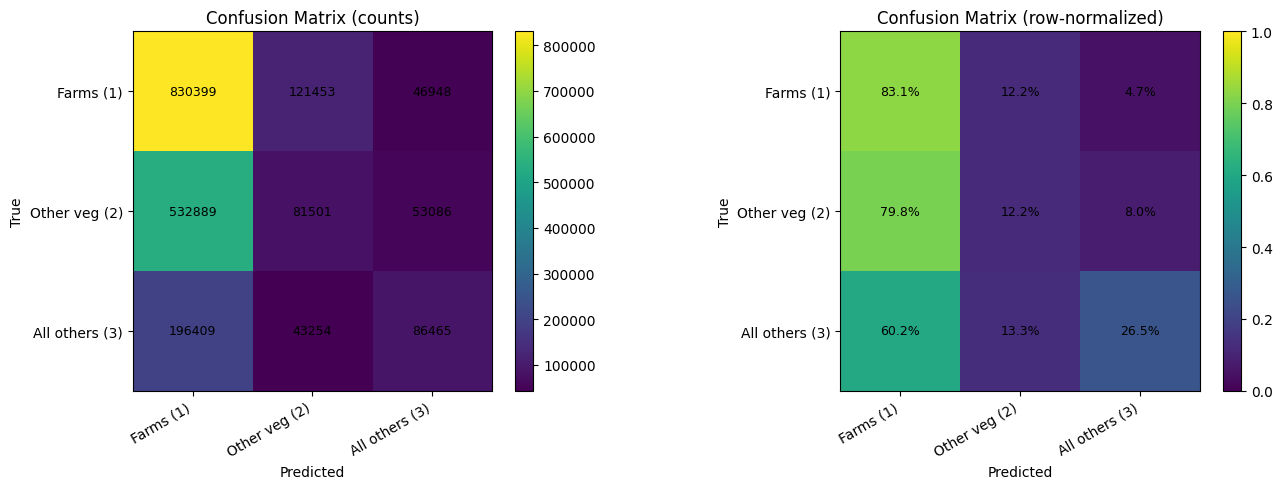

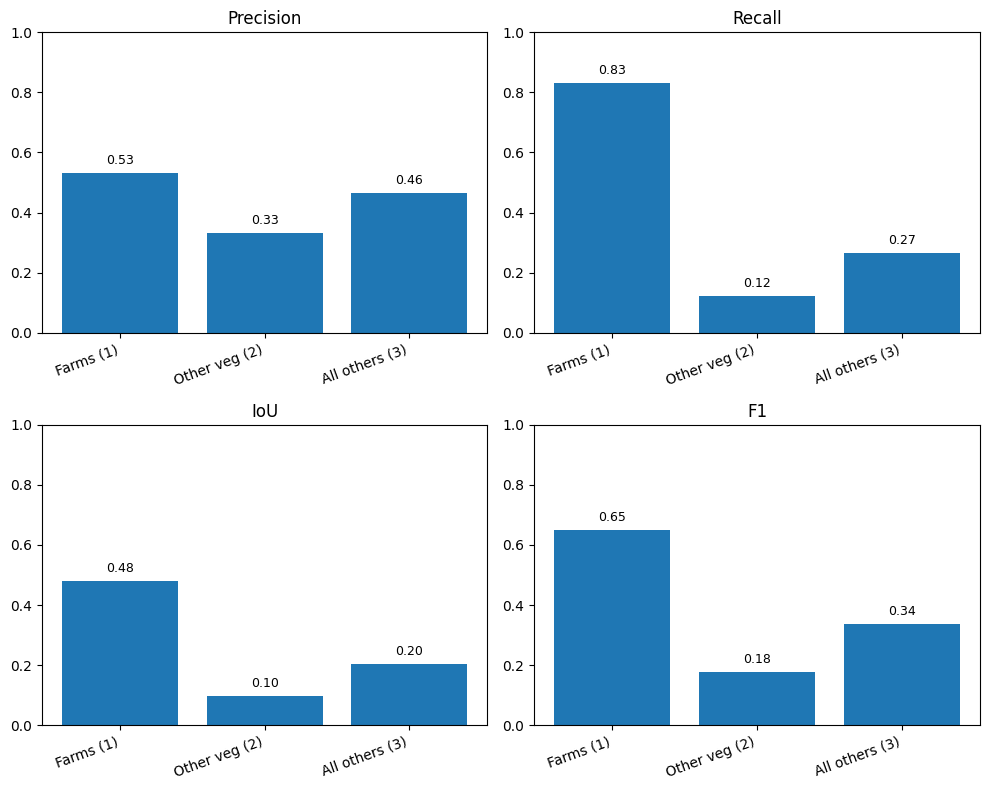

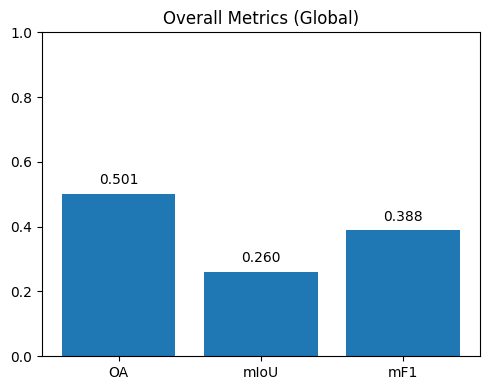

In [9]:
cm = metrics_cm
per = metrics_per_class
ov  = metrics_overall
class_names = per["class_names"]

# --- 1) Confusion matrix heatmap (counts + normalized) ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# counts
im0 = ax[0].imshow(cm, interpolation='nearest')
ax[0].set_title("Confusion Matrix (counts)")
ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("True")
ax[0].set_xticks(range(len(class_names))); ax[0].set_yticks(range(len(class_names)))
ax[0].set_xticklabels(class_names, rotation=30, ha='right')
ax[0].set_yticklabels(class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax[0].text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=9)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# row-normalized (%)
row_sums = cm.sum(axis=1, keepdims=True).astype(float)
norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums!=0)
im1 = ax[1].imshow(norm, interpolation='nearest', vmin=0.0, vmax=1.0)
ax[1].set_title("Confusion Matrix (row-normalized)")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("True")
ax[1].set_xticks(range(len(class_names))); ax[1].set_yticks(range(len(class_names)))
ax[1].set_xticklabels(class_names, rotation=30, ha='right')
ax[1].set_yticklabels(class_names)
for i in range(norm.shape[0]):
    for j in range(norm.shape[1]):
        ax[1].text(j, i, f"{norm[i, j]*100:.1f}%", ha="center", va="center", fontsize=9)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- 2) Four bar plots: Precision, Recall, IoU, F1 ---
metrics_list = [("Precision", per["precision"]),
                ("Recall",    per["recall"]),
                ("IoU",       per["iou"]),
                ("F1",        per["f1"])]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()
for k, (title, vals) in enumerate(metrics_list):
    axs[k].bar(range(len(class_names)), vals)
    axs[k].set_title(title)
    axs[k].set_ylim(0, 1)
    axs[k].set_xticks(range(len(class_names)))
    axs[k].set_xticklabels(class_names, rotation=20, ha='right')
    for i, v in enumerate(vals):
        axs[k].text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# --- 3) Overall metrics bar plot: OA, mIoU, mF1 ---
overall_names = ["OA", "mIoU", "mF1"]
overall_vals  = [ov["oa"], ov["mIoU"], ov["mF1"]]

plt.figure(figsize=(5,4))
plt.bar(range(len(overall_names)), overall_vals)
plt.xticks(range(len(overall_names)), overall_names)
plt.ylim(0, 1)
for i, v in enumerate(overall_vals):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
plt.title("Overall Metrics (Global)")
plt.tight_layout()
plt.show()

# Summary

## Model Architecture

A compact and configurable U-Net (“UNetFlex”) model is implemented in PyTorch for this project. This architecture was chosen for its flexibility, allowing easy adjustment of individual hyperparameters to assess their impact. The range of values for each hyperparameter was selected to balance model performance with the time, storage, and memory constraints of the CRIB platform.

**Key Components**

1. **DoubleConv**: This is the basic building block of the model. It consists of two convolutional layers with ReLU activation functions, and optionally includes Batch Normalisation (BN) and Dropout based on configuration parameters. This block helps in learning complex feature representations.

2. **Encoder (Contracting Path)**:

   * The encoder consists of multiple layers (defined by "unet_depth"). Each layer applies the "DoubleConv" block, progressively increasing the number of filters (specified as "base_filters").
   * After each convolution block, a max-pooling operation reduces spatial dimensions, enabling the network to capture more abstract features.

3. **Decoder (Expansive Path)**:

   * The decoder consists of transposed convolution layers ("ConvTranspose2d") that upsample the feature maps, followed by "DoubleConv" blocks for refining the upsampled features.
   * Skip connections are used between the encoder and decoder, concatenating the feature maps from the encoder at each corresponding level of the decoder. This helps in recovering spatial information lost during downsampling.

4. **Output Layer**: The final layer is a 1x1 convolution that reduces the feature map to the number of output classes ("n_classes"), generating the segmentation map.

**Model Parameters:**

* **Input Channels ("in_ch")**: Number of channels in the input image (e.g., 3 for RGB images).
* **Output Classes ("n_classes")**: The number of classes for segmentation (e.g., 3 for multi-class segmentation).
* **Base Filters ("base")**: The base number of filters in the first convolution block, which doubles at each deeper layer.
* **Depth ("depth")**: The number of encoder-decoder levels (minimum 3).
* **Batch Normalisation ("use_bn")**: Adds batch normalisation after each convolution to stabilise training by normalising the activations, improving convergence speed and reducing the need for careful initialisation.
* **Dropout Probability ("p_drop")**: Defines the rate at which neurons are dropped during training to prevent overfitting. A 0.0 value means no dropout is applied.

**Loss Functions:**

* **Cross-Entropy Loss (CE)**: Used for pixel-wise classification by comparing predicted probabilities with true labels, penalising incorrect predictions.
* **Dice Loss**: Measures the overlap between predicted and true segmentation masks, often used for imbalanced datasets.
* **Focal Loss**: A variation of cross-entropy loss that down-weights easy examples, helping with class imbalance.
* **Combined Loss**: A mixture of cross-entropy and dice loss can be used for improved performance.

**Augmentation:**

The model includes data augmentation capabilities (flipping, rotation) to improve robustness and generalisation.

**Optimiser and Training:**

* **Optimiser**: A variant of Adam that includes weight decay to prevent overfitting, adapting learning rates for each parameter to improve convergence.
* **Learning Rate**: The step size used in weight updates during training. A 1e-3 rate is commonly used to balance fast convergence and stability.
* **Mixed Precision Training (AMP)**: Uses both 16-bit and 32-bit precision to reduce memory usage and speed up training without sacrificing model performance.

## Performace Evaluation

The model trained using only RGB tiles achieved an overall accuracy (OA) of 0.50, a mean F1 score of 0.39, and a mean IoU of 0.26, indicating limited segmentation performance. While the model performed reasonably well for the “Farms” class (F1 = 0.65), the “Other vegetation” and “All others” classes were predicted less accurately, with F1 scores of 0.18 and 0.34, respectively. The confusion matrix shows that many “Other vegetation” pixels were misclassified as “Farms,” suggesting that the model struggled to separate spectrally similar classes when relying only on RGB information.

This result is expected because RGB imagery alone does not capture near-infrared (NIR) reflectance, which is critical for distinguishing between different types of vegetation. The three visible bands mainly provide colour and brightness information, which are not sufficient for identifying subtle spectral differences between crop and non-crop vegetation. Consequently, the model over-relied on visual texture and intensity cues, leading to lower overall segmentation accuracy, mean F1, and mean IoU values.
